In [1]:
library(tidyverse)
library(data.table)
library(repr)


── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

The following object is masked from ‘package:purrr’:

    transpose



In [29]:
repo_root <- normalizePath('../../')


In [3]:
dataset_list <- list(
#     'snpnet_biomarker' = c('biomarkers_20190407', 'biomarkers_20190407_multi_ethnic')
    'snpnet_biomarker' = c('biomarkers_20190407')    
)

In [4]:
get_stats_filename <- function(dataset_name, method_name, repo_root){
    file <- file.path(
        repo_root, 
        'public_output', 
        paste0(method_name, '_PRS'), 
        paste0(dataset_name, '.tsv')
    )
    return(file)
}

In [5]:
read_datasets <- function(method_name, named_dataset_list, repo_root){
    named_dataset_list[method_name][[1]] %>%
    lapply(               
        function(x){
            dataset_n <- str_split(x, '_') %>% simplify() %>% first()
            dataset_v <- str_split(x, '_') %>% simplify() %>% last()            
            df <- tryCatch(                
                x %>%
                get_stats_filename(method_name, repo_root) %>%
                fread(data.table=FALSE) %>%
                mutate(
                    method = method_name,
                    dataset_name = dataset_n,
                    dataset_version = dataset_v,
                    dataset_full = x
                ),
                error=function(e){NULL}
            )
            if(!is.null(df)) {
                colnames(df) <- gsub("^#", "", colnames(df))
            }
            df
        }
    ) %>%
    bind_rows()
}


In [6]:
read_all_data <- function(dataset_named_list, repo_root){
    dataset_named_list %>% names() %>% lapply(
        function(x){
            read_datasets(x, dataset_named_list, repo_root)
        }
    ) %>% 
    bind_rows() %>%
    replace_na(list(N = 0))
    
}

In [7]:
final_list <- fread(
    'list_of_phes.txt', head=FALSE
)
colnames(final_list) <- c('GBE_ID')

In [8]:
df <- dataset_list %>% read_all_data(repo_root) %>% 
inner_join(final_list) %>% 
replace_na(list(Population = 'white_british')) %>%
select(-method, -PRS_model, -dataset_name, -dataset_version, -dataset_full)

Joining, by = "GBE_ID"


In [9]:
df %>% dim()

[1] 513   5

In [10]:
plot_width <- 7
plot_height <- 7
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

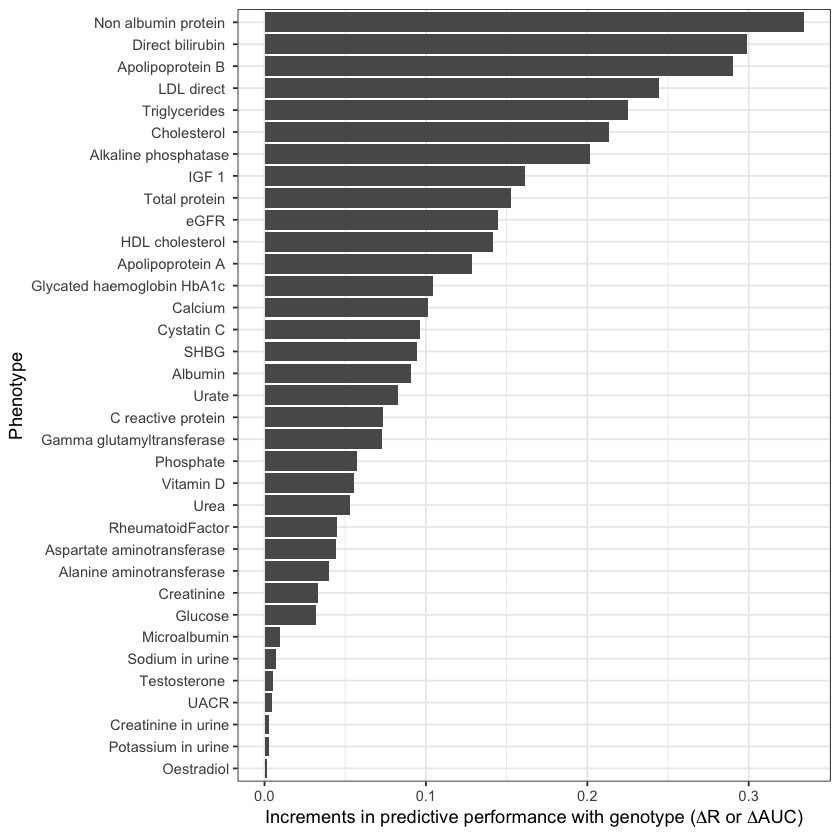

In [11]:
df %>%
filter(Population == 'white_british') %>%
spread(features, R_or_AUC) %>%
mutate(
    label = str_replace_all(GBE_ID, '_', ' '),
    label = str_replace_all(label, 'adjstatins', ''),
    label = str_replace_all(label, 'Normal', ''),
    delta_R_or_AUC = Genotype_and_covariates - Covariates_only
) %>% 
ggplot(
    aes(x = reorder(label, delta_R_or_AUC), y=delta_R_or_AUC)
)+ theme_bw() + 
theme(
    strip.text = element_text(size=7)
    )+ 
coord_flip()+
geom_bar(stat = 'identity') +
labs(
    x = 'Phenotype',
    y = expression("Increments in predictive performance with genotype ("*Delta*"R or "*Delta*"AUC)")
)

In [12]:
ggsave('snpnet.png')

Saving 7 x 7 in image


Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”

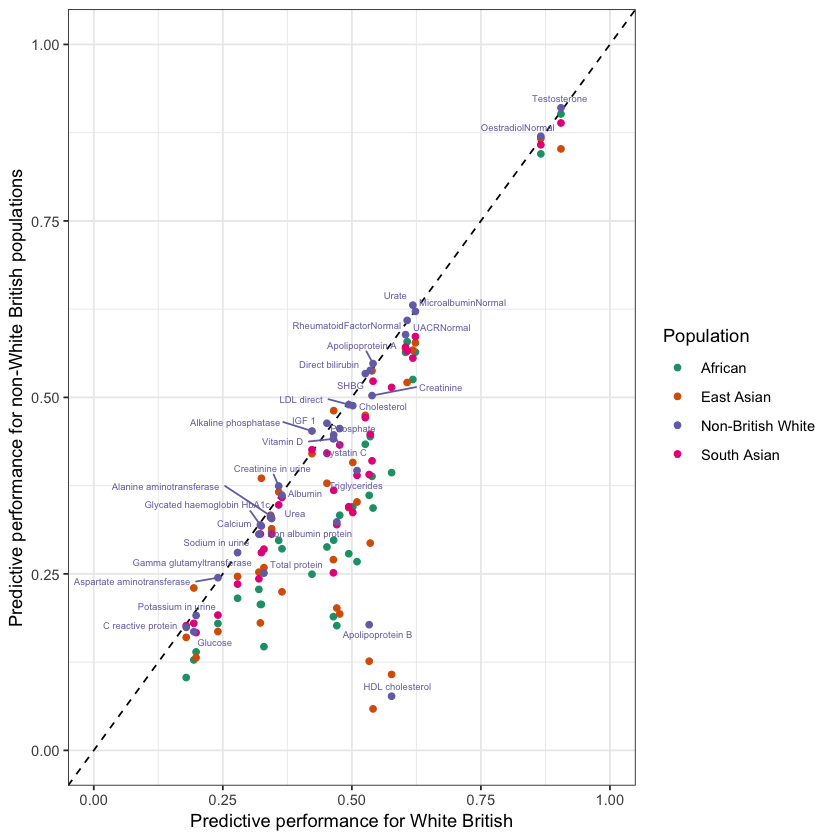

In [30]:
df %>%
spread(Population, R_or_AUC) %>%
mutate(
    label = str_replace_all(GBE_ID, '_', ' '),
    label = str_replace_all(label, 'adjstatins', '')
) %>%
gather("Population", "R_or_AUC", c('african', 'e_asian', 's_asian', 'non_british_white')) %>%
filter(
    features == 'Genotype_and_covariates'
) %>% 
mutate(
    label = if_else(Population == 'non_british_white', label, ''),
    Population = str_replace(Population, 'african', 'African'),
    Population = str_replace(Population, 's_asian', 'South Asian'),
    Population = str_replace(Population, 'e_asian', 'East Asian'),
    Population = str_replace(Population, 'non_british_white', 'Non-British White')
) %>%
ggplot(
    aes(x = white_british, y=R_or_AUC, color=Population, label=label)
)+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed") + 
geom_point(stat = 'identity') +
xlim(0, 1) + ylim(0, 1) + 
labs(
    x = 'Predictive performance for White British',
    y = 'Predictive performance for non-White British populations'
) + 
ggrepel::geom_text_repel(size=2) + 
scale_color_brewer(palette="Dark2")

In [31]:
ggsave('snpnet-multi-ethnic.png')

Saving 7 x 7 in image
Warning message:
“Removed 4 rows containing missing values (geom_point).”Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”

Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_text_repel).”

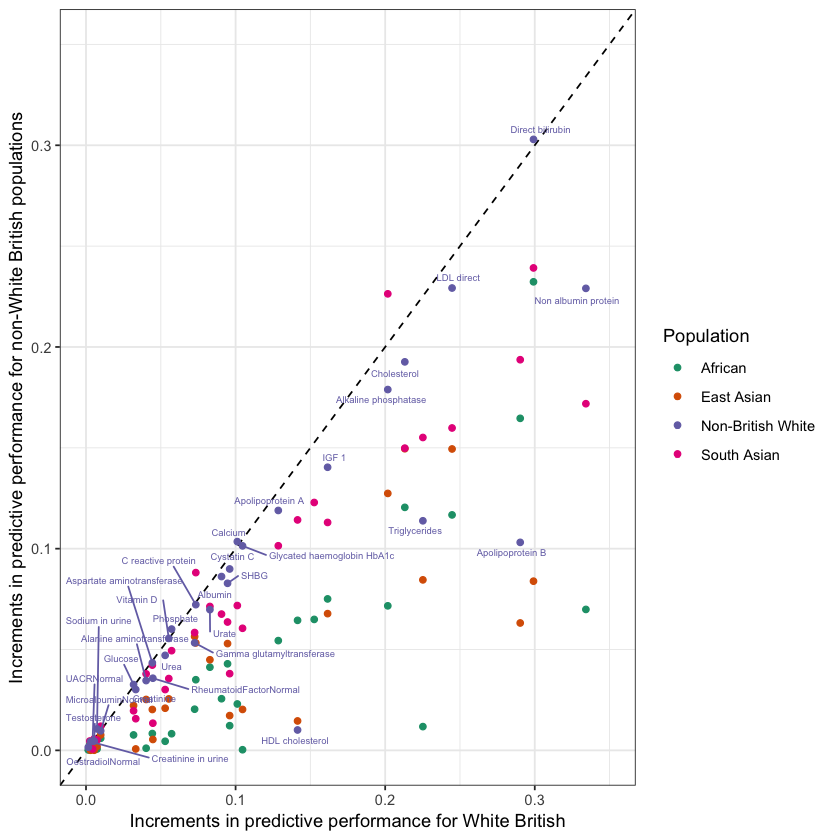

In [33]:
df %>%
spread(features, R_or_AUC) %>%
mutate(
    label = str_replace_all(GBE_ID, '_', ' '),
    label = str_replace_all(label, 'adjstatins', ''),
    delta_R_or_AUC = Genotype_and_covariates - Covariates_only
) %>%
gather(
    "features", "R_or_AUC", c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only', 'delta_R_or_AUC')
) %>%
spread(Population, R_or_AUC) %>%
gather("Population", "R_or_AUC", c('african', 'e_asian', 's_asian', 'non_british_white')) %>%
filter(
    features == 'delta_R_or_AUC'
) %>% 
mutate(
    label = if_else(Population == 'non_british_white', label, ''),    
    Population = str_replace(Population, 'african', 'African'),
    Population = str_replace(Population, 's_asian', 'South Asian'),
    Population = str_replace(Population, 'e_asian', 'East Asian'),
    Population = str_replace(Population, 'non_british_white', 'Non-British White')
) %>%
ggplot(
    aes(x = white_british, y=R_or_AUC, color=Population, label=label)
)+ 
theme_bw() + 
theme(
    strip.text = element_text(size=7)
)+ 
geom_abline(slope=1, intercept=0, linetype = "dashed") + 
geom_point(stat = 'identity') +
xlim(0, .35) + ylim(0, .35) + 
labs(
    x = 'Increments in predictive performance for White British',
    y = 'Increments in predictive performance for non-White British populations'
) + 
ggrepel::geom_text_repel(size=2) + 
scale_color_brewer(palette="Dark2")

In [34]:
ggsave('snpnet-multi-ethnic-delta.png')

Saving 7 x 7 in image
Warning message:
“Removed 19 rows containing missing values (geom_point).”Warning message:
“Removed 19 rows containing missing values (geom_text_repel).”

In [35]:
bias_df <- df %>%
spread(features, R_or_AUC) %>%
mutate(
    label = str_replace_all(GBE_ID, '_', ' '),
    label = str_replace_all(label, 'adjstatins', ''),
    delta_R_or_AUC = Genotype_and_covariates - Covariates_only
) %>%
gather(
    "features", "R_or_AUC", c('Covariates_only', 'Genotype_and_covariates', 'Genotype_only', 'delta_R_or_AUC')
) %>%
spread(Population, R_or_AUC) %>%
gather("Population", "R_or_AUC", c('white_british', 'african', 'e_asian', 's_asian', 'non_british_white')) %>%
filter(
    features == 'delta_R_or_AUC'
) %>% 
mutate(
    Population = str_replace(Population, 'african', 'African'),
    Population = str_replace(Population, 's_asian', 'South Asian'),
    Population = str_replace(Population, 'e_asian', 'East Asian'),
    Population = str_replace(Population, 'non_british_white', 'Non-British White')
) %>%
group_by(GBE_ID)%>%
mutate(
    rank_R_or_AUC = rank(-R_or_AUC),
    rank_R_or_AUC = paste0('Rank_', rank_R_or_AUC)
) %>%
ungroup() %>%
count(Population, rank_R_or_AUC) %>%
spread(rank_R_or_AUC, n, fill =0) %>%
arrange(-Rank_1, -Rank_2, -Rank_3, -Rank_4, -Rank_5)

In [36]:
bias_df

Population,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5
white_british,21,13,1,0,0
Non-British White,9,13,7,3,3
South Asian,5,7,18,3,2
African,0,2,5,9,19
East Asian,0,0,4,20,11


In [41]:
bias_df %>% 
fwrite('PRS_bias.tsv', row.names=F, col.names=T, sep='\t')

#### here is the status of the jobs

In [28]:
df %>% filter(
    features == 'Genotype_and_covariates',
) %>% count(
    Population, GBE_ID
) %>% spread(
    Population, n, fill =0
) %>% 
right_join(final_list)

Joining, by = "GBE_ID"


GBE_ID,african,e_asian,non_british_white,s_asian,white_british
Alanine_aminotransferase_adjstatins,1,1,1,1,1
Albumin_adjstatins,1,1,1,1,1
Alkaline_phosphatase,1,1,1,1,1
Apolipoprotein_A_adjstatins,1,1,1,1,1
Apolipoprotein_B_adjstatins,1,1,1,1,1
Aspartate_aminotransferase_adjstatins,1,1,1,1,1
Calcium_adjstatins,1,1,1,1,1
Cholesterol_adjstatins,1,1,1,1,1
C_reactive_protein_adjstatins,1,1,1,1,1
Creatinine_adjstatins,1,1,1,1,1


### previous notebooks

In [23]:
plot_width <- 10
plot_height <- 30
options(repr.plot.width=plot_width , repr.plot.height=plot_height)

In [24]:
p <- df %>% 
mutate(
    adj_statins = if_else(endsWith(GBE_ID, '_adjstatins'), 'Yes', 'No', missing = NULL),
    phe_name = str_replace(str_replace(GBE_ID, '_adjstatins$', ''), '_', ' ')
) %>%
ggplot(
    aes(x = adj_statins, y=R_or_AUC, fill = adj_statins)
) + 
geom_bar(stat = 'identity') + 
facet_grid(phe_name~features, space='free_x') +
theme(
    axis.title.x=element_blank(),
#     axis.text.x = element_text(angle = 30, hjust = 1),    
    axis.text.x=element_blank(),    
    axis.ticks.x=element_blank(),
    legend.position="bottom"
) + 
labs(
    y = 'R or AUC',
    title = 'Biomarker run results (2019/4/7)',
    fill = 'Statins adjustment'
) + 
scale_fill_brewer(palette = "Set2") +
guides(fill=guide_legend(nrow=2,byrow=TRUE))

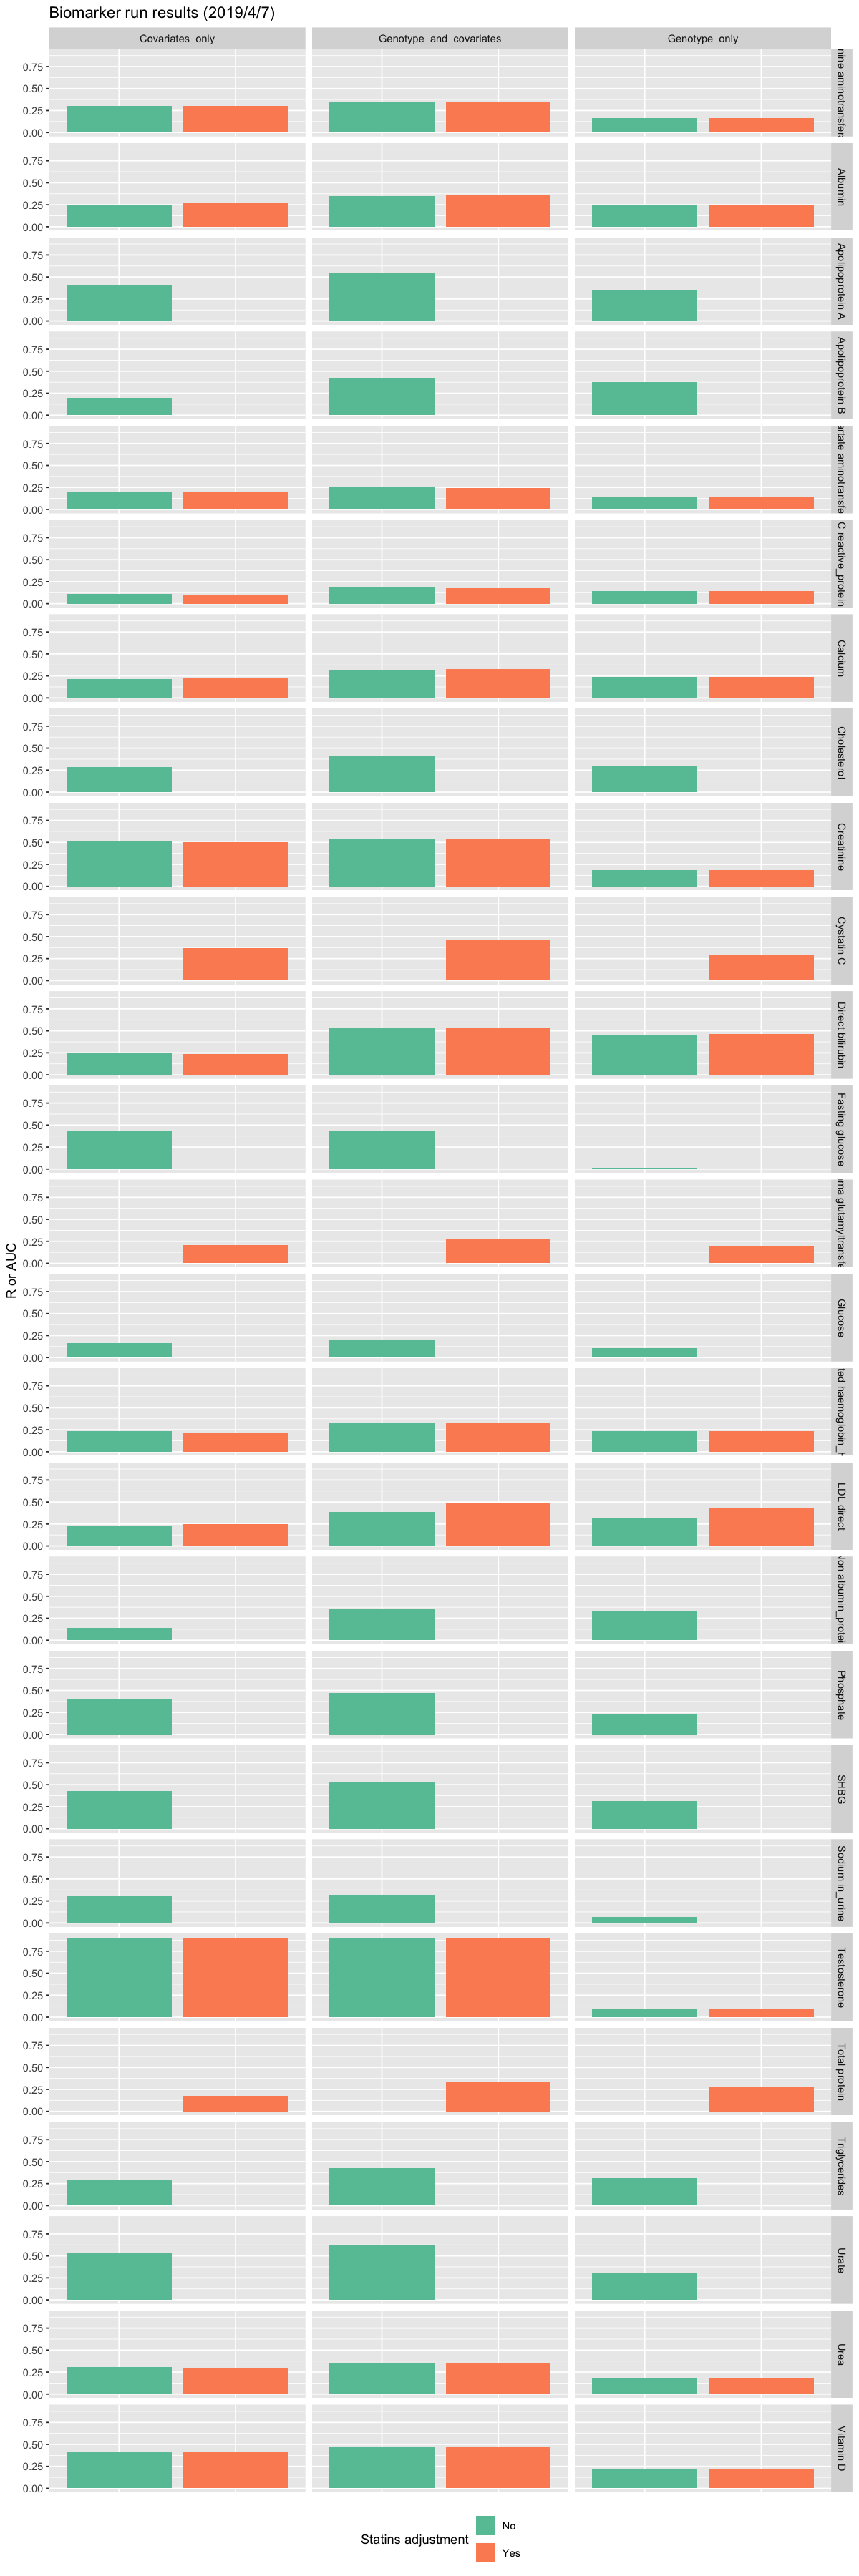

In [25]:
p + ggsave(
    'snpnet_biomarkers_20190407.png',
    width = plot_width, height = plot_height
)
